# Introduction
This is a very basic portfolio optimizer. Based on a list of stocks and their monthly return for during the past 5 years, the optimization will minimize the risks (standard deviation in this case) while achieving a required return.
Again, this is a very basic and naive optimizer, more feature will be added on as I learned more
Stock data are gather using the yfinance library
Optimization is performed using cvxpy library

## 0. Import Libraries

In [19]:
import cvxpy as cp
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

print ("finished loading libraries")


finished loading libraries


## 1. Prepare Helper function

In [20]:

def load_symbol(symbol_list, period = "5y"):
    """ Given a stock symbol and period of interest, load data from yahoo finance and return a panda dataframe """

    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

    # example input: symbol = ["SPY", "APPL"] period = "5y"
    # will download data for SPY and Apple for the past 5 year from today

    try: 
        DF = yf.download(symbol_list, period = period)
        return (DF)
    except:
        print ("Failure parsing Yahoo Finance Data")
    
def select_adjclose_column (DF):
    """given a yahoo finance dataframe, select the adjusted close column"""

    return (DF["Adj Close"])


def fill_missing_values (DF):
    """ given a yahoo finance dataframe
    in case there are missing values, foward fill first followed by back fill """
    DF = DF.fillna(method = "ffill")
    DF = DF.fillna(method = "bfill")
    return (DF)

def compute_monthly_return(DF):
    """ given a yahoo finance dataframe, calculate monthly return """
    return (DF.resample('M').ffill().pct_change()[1:])

def compute_mean_return (DF, show = False):
    """ given a dataframe, calculate mean return for each column """
    if (show == True):
        DF_temp = pd.DataFrame(DF.mean(), columns = ["Mean Return"])

        print ("The risk of the selected stocks are the following: ")
        display (DF_temp)

    return (DF.mean())


def compute_covariance(DF):
    """ given a dataframe, calcualte covariance"""
    return (DF.cov())


def compute_variance(DF, show = False):
    """ given a dataframe, calcualte variance"""

    if (show == True):
        DF_temp = pd.DataFrame(DF.var(), columns = ["Variance"])
        display (DF_temp)
    return (DF.var())

def compute_std(DF, show = False):
    """ given a dataframe of stock return, calcualte standard deviation (or risk)"""

    if (show == True):
        DF_temp = pd.DataFrame(DF.std(), columns = ["std (risk"])
        display (DF_temp)
    return (DF.std())

def compute_sharpe_ratio(DF, period = "M", risk_free_rate = 0):
    
    """calcuate sharpe ratio for individual stocks given a dataframe (containing return data)

    Parameters: 
    DF: A dataframe containing monthly return

    period has three options 
    "M" stands for monthly
    "W" stands for weekly
    "D" stands for daily
    
    the risk_free_rate is assumed to be annual rate, defaulted to be zero

    Returns:
    A dataframe containing sharpe ratio for each stock

    """
    # calculate the coefficient and make the rate to the corresponding period

    if (period == "M"):
        coef = np.array(12**0.5)
        risk_free_rate = np.array(risk_free_rate/12.0)
    elif (period == "W"):
        coef = np.array(52**0.5)
        risk_free_rate = np.array(risk_free_rate/52.0)
    elif (period == "D"):
        coef  = np.array(252**0.5)
        risk_free_rate = np.array(risk_free_rate/252.0)
    else:
        print ("period not specfied or not in one of the available values, assumed the period to be monthly")
        coef = np.array(12**0.5)

    temp_DF = coef * (DF.mean() - risk_free_rate)/DF.std()

    return (temp_DF)


def compute_sharpe_ratio_portfolio(DF, weight, period = "M", risk_free_rate = 0):
    
    """calcuate sharpe ratio for the entire portfolio given a dataframe containing return data

    Parameters: 
    DF: A dataframe containing monthly return
    weight:  a list of float indicating the weight of the stocks in the portfolio

    period has three options 
    "M" stands for monthly
    "W" stands for weekly
    "D" stands for daily

    the risk_free_rate is assumed to be annual rate, defaulted to be zero

    Returns:
    A float indicating the sharpe ratio of the portfolio
    """
    # calculate the coefficient and make the rate to the corresponding period

    if (period == "M"):
        coef = np.array(12**0.5)
        risk_free_rate = np.array(risk_free_rate/12.0)
    elif (period == "W"):
        coef = np.array(52**0.5)
        risk_free_rate = np.array(risk_free_rate/52.0)
    elif (period == "D"):
        coef  = np.array(252**0.5)
        risk_free_rate = np.array(risk_free_rate/252.0)
    else:
        print ("period not specfied or not in one of the available values, assumed the period to be monthly")
        coef = np.array(12**0.5)

    weight = np.array(weight)

    # calcuate return by date (mean columnwise)
    weighted_return = DF.multiply(weight).sum(axis = 1)

    mean_return = weighted_return.mean()
    std = weighted_return.std()

    sharpe_ratio = coef * (mean_return - risk_free_rate)/std

    return (sharpe_ratio)









## 2. Optimization
### 2.1 Select symbols to analyze
 For this example, I gather the past 5 years of data for the Dow Jones 30 Index and calculated monthly return using adjusted close.

In [21]:


# select Dow Jones 30 Index's holdings
symbol_list = ["MMM", "AXP", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DOW", "XOM", "GS", "HD", "IBM", "INTC", "JNJ", "JPM", "MCD","MRK", "MSFT", "NKE", "PFE", "PG", "TRV", "UNH", "UTX", "VZ", "V", "WMT", "WBA", "DIS"]

# Load Yahoo Data
DF =  load_symbol(symbol_list, period = "5y")

# select adjusted close and fill missing values (especially for the DOW Company)
DF = fill_missing_values(select_adjclose_column(DF))

# calculate monthly return and assign it to DF1
DF1 = compute_monthly_return(DF)
DF1.head(10)







[*********************100%***********************]  30 of 30 downloaded


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DOW,GS,HD,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-30,-0.017012,-0.022437,0.004516,-0.092124,0.014988,-0.078249,-0.009374,0.0,0.024881,-0.013854,...,0.006105,0.007475,-0.002367,-0.000748,-0.022000,0.003950,0.003529,-0.020776,0.012923,-0.054382
2014-10-31,0.071931,0.030602,-0.019333,0.031830,-0.027688,0.005344,0.026325,0.0,0.034989,0.062977,...,0.012945,0.050259,0.073081,0.101610,0.013220,0.131615,0.016328,0.083552,-0.002670,0.028241
2014-11-30,0.105954,0.027419,0.081882,-0.007886,0.129568,-0.084032,0.012411,0.0,-0.005175,0.019369,...,0.049121,0.036124,0.036153,0.038074,0.034407,0.077538,0.006920,0.073817,0.147702,-0.057054
2014-12-31,-0.071898,0.006759,-0.032545,-0.090240,0.006303,0.030469,0.031057,0.0,0.028780,0.061026,...,0.000000,0.007333,0.018779,0.028818,0.044756,0.015650,-0.075356,0.110537,-0.013478,0.021184
2015-01-31,0.061443,-0.130223,0.118353,-0.119106,-0.045511,-0.085996,-0.034311,0.0,-0.110525,-0.005267,...,0.003045,-0.068072,-0.028592,0.051034,-0.001947,-0.027800,-0.011415,-0.032113,-0.010510,-0.054454
2015-02-28,0.100769,0.011179,0.044102,0.036610,0.118985,0.050598,0.144348,0.0,0.104301,0.099015,...,0.108159,0.010004,0.044852,0.069453,0.067896,0.072059,0.081901,0.131212,-0.012347,0.020431
2015-03-31,-0.031384,-0.039352,-0.005102,-0.034614,-0.059812,-0.015903,0.007685,0.0,-0.009624,-0.004914,...,0.013699,-0.037449,0.011660,0.044554,-0.038641,-0.035665,-0.016629,0.019244,-0.014115,-0.039909
2015-04-30,0.005820,-0.008631,-0.044868,0.094593,0.046985,0.057880,0.036608,0.0,0.044972,-0.058294,...,-0.025000,-0.021849,-0.064973,-0.058287,-0.029456,0.009799,0.048965,-0.020573,-0.050995,0.027852
2015-05-31,0.045341,0.029436,-0.013422,-0.017976,0.016680,-0.063272,0.015107,0.0,0.052984,0.041440,...,0.032918,-0.014123,0.000109,0.079071,0.035735,0.041634,-0.019731,0.039085,-0.042385,-0.016748


### 2.2 Set and solve optimization problem using the strategies of minimizing risk given a required return

In [22]:
# set up for optimization problems
# number of stocks
n = len(DF1.columns)

# set up the composition of stocks in the portfolio
x = cp.Variable(n)

# convert return dataframe to matrix form then transpose
mean_return = compute_mean_return(DF1).values

print ("For the selected period, the average monthly return for all stock is {:.4f}%".format(100.0 * mean_return.mean()))

print ("For the selected period, the maximum monthly return for all stock is {:.4f}%".format(100.0 * mean_return.max()))

# specify required return
req_return = 0.015

# Calculate expected return
expected_return = mean_return.T*x

# compute risk
risk = cp.quad_form(x, compute_covariance(DF1))

# Set up objective and contraints
# 1. objective is minimize risk
objective = cp.Minimize(risk)

# 2. constains include sum of x must be 1, x must be >= 0
# expected return should be greater than required return
# each individual stock could not be higher than a certain percentage (diversification)

constraints = [cp.sum(x) == 1, expected_return >= req_return, x >=0, x <= 0.3]

prob = cp.Problem(objective, constraints)

# solve problem and write solution
try:
    prob.solve()

    # after the .solve() method 
    # the value of x will change since it is a cp.Variable object

    print ("----------------------")
    print ("Optimal portfolio")
    print ("----------------------")

    portfolio_DF = pd.DataFrame({"Ticker":symbol_list, "Percentage": np.round(x.value,4)*np.array(100.0)})

    display(portfolio_DF)


    print ("----------------------")

    print ('Exp return = {:.4f}%'.format(expected_return .value*100))
    print ('risk    = {:.4f}'.format((risk.value)**0.5))

    print ("----------------------")
except:
    print ('Error')




For the selected period, the average monthly return for all stock is 0.9759%
For the selected period, the maximum monthly return for all stock is 2.2407%
----------------------
Optimal portfolio
----------------------
----------------------
Exp return = 1.5000%
risk    = 0.0270
----------------------


,Ticker,Percentage
0,MMM,-0.00
1,AXP,0.00
2,AAPL,4.04
3,BA,0.00
4,CAT,0.00
5,CVX,0.00
6,CSCO,0.00
7,KO,8.98
8,DOW,0.00
9,XOM,0.07


### 2.3 Wrap the optimization routine in function and obtain efficient frontier

In [23]:
def compute_frontier(DF, max_indi_allocation = 0.3, num_points = 50, risk_free_rate = 0):

    """Compute the weights, return, and risk for plot the efficent frontier 
    
    Paramters:
    DF: A dataframe of stocks with returns
    min_ticker_count
    max_indi_allocation: maximum portfolio allocation for each stock
    num_points: An integer indicating the number of points for simulation


    Returns:
    A tuple of numpy arrays
    (weights, mean_return, standard_deviation, sharpe ratio)

    """

    n = len(DF.columns)
    
    x = cp.Variable(n)

    mean_return = compute_mean_return(DF).values

    max_return = mean_return.max() #obtain maximum return for the stocks

    return_vector = np.linspace(0,max_return, num_points)


    # initialize numpy array for storing results
    weight_vector = np.zeros((1, n))
    risk_vector = np.zeros((0))
    expected_return_vector = np.zeros((0))
    sharpe_vector = np.zeros((0))

    for (index, req_return) in enumerate(return_vector):

        print (index,req_return)



        expected_return = mean_return.T*x
        risk = cp.quad_form(x, compute_covariance(DF))

        objective = cp.Minimize(risk)

        constraints = [cp.sum(x) == 1, expected_return >= req_return, x >= 0, x <= max_indi_allocation]

        prob = cp.Problem(objective, constraints)

        try:
            prob.solve()

           
            print ("Optimal portfolio")
            print ("----------------------")

            print ('Exp return = {:.4f}%'.format(expected_return .value*100))
            print ('risk    = {:.4f}'.format((risk.value)**0.5))

            # append to vector

            print (x.value.shape)

            weight_vector = np.append(weight_vector, x.value.reshape(1,n), axis = 0)

            risk_vector = np.append(risk_vector, (risk.value)**0.5)

            expected_return_vector = np.append(expected_return_vector, expected_return.value)

            sharpe_vector = np.append(sharpe_vector, compute_sharpe_ratio_portfolio(DF, x.value, risk_free_rate = risk_free_rate))
        except:
            # if there is no solution, do nothing
            pass
            

    print ("finished looping")

    return (weight_vector.round(4), expected_return_vector.round(4), risk_vector.round(4), sharpe_vector.round(4))


# run the above function
(weight,ret, std,sharpe) = compute_frontier(DF1)


0 0.0
Optimal portfolio
----------------------
Exp return = 0.7371%
risk    = 0.0227
(30,)
1 0.0004572765812151744
Optimal portfolio
----------------------
Exp return = 0.7371%
risk    = 0.0227
(30,)
2 0.0009145531624303488
Optimal portfolio
----------------------
Exp return = 0.7371%
risk    = 0.0227
(30,)
3 0.0013718297436455232
Optimal portfolio
----------------------
Exp return = 0.7371%
risk    = 0.0227
(30,)
4 0.0018291063248606976
Optimal portfolio
----------------------
Exp return = 0.7371%
risk    = 0.0227
(30,)
5 0.002286382906075872
Optimal portfolio
----------------------
Exp return = 0.7371%
risk    = 0.0227
(30,)
6 0.0027436594872910463
Optimal portfolio
----------------------
Exp return = 0.7371%
risk    = 0.0227
(30,)
7 0.003200936068506221
Optimal portfolio
----------------------
Exp return = 0.7371%
risk    = 0.0227
(30,)
8 0.0036582126497213953
Optimal portfolio
----------------------
Exp return = 0.7371%
risk    = 0.0227
(30,)
9 0.004115489230936569
Optimal portfoli

### 2.4 Plot Efficient Frontier
 The Efficient Frontier show the minimum risk for the given level of return. The ratio of return/standard deviation is also called the sharpe ratio (risk adjusted return)
 In the plot below, the blue line indicating the efficiency frontier, and the red diamond indicates the monthly return and standard deviation for each stock in the selection

In [24]:
#import library
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import LinearAxis, Range1d
from bokeh.io import export_png

# display plot inline in notebook
output_notebook()

p = figure(x_axis_label = "Standard Deviation", y_axis_label = "monthly return", plot_width=600, plot_height=400, title="Efficient Fronter")

# add a line renderer
p.line(std, ret, line_width=2, legend = "Optimized Portfolio")

# add individual simulation point
p.circle(std,ret,size = 4)

# add individual point for each stock
p.diamond(compute_std(DF1).values, compute_mean_return(DF1).values, color = "red", size = 4, legend = "Individual Stocks")

p.y_range = Range1d(0,np.nanmax(ret) + 0.005)


# add the sharpe ratio for the portfolio as the second y axis
p.extra_y_ranges = {"sharpe":Range1d(start = 0, end = 2.5)}
p.add_layout(LinearAxis(y_range_name = "sharpe", axis_label='Sharpe Ratio'), "right")
p.triangle(std,sharpe, size = 4, color = "orange", y_range_name = "sharpe", legend = "Sharpe Ratio")
p.legend.location = "bottom_left"

show(p)

# export to png
try:
    export_png(p, filename="Fig 1.1.PNG")
except:
    pass



Loading BokehJS ...

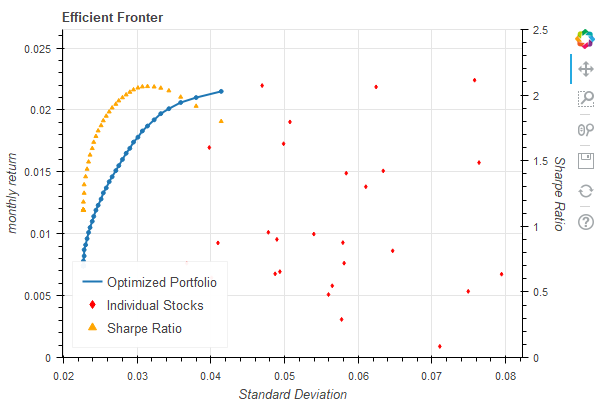

In [25]:

#work around because Bokeh will not load when uploaded as a Jupyter Notebook on Github

%matplotlib inline
from IPython.display import Image

try:
    display(Image(filename = "Fig 1.1.PNG"))
except:
    pass




## 2.5 Best Portfolio so far
 Based on the plot above, I would select the portfolio with the highest sharpe ratio, which has approximately 1.8% of monthly return with a standard deviation of 0.032.
 The dataframe belows shows the optimized portfolio after considering Sharpe Ratio.

In [26]:
portfolio_DF = pd.DataFrame({"Ticker":symbol_list, "Percentage": 100.0*weight[np.argmax(sharpe)]})

display(portfolio_DF[portfolio_DF["Percentage"] > 0.0001])



,Ticker,Percentage
2,AAPL,5.68
15,JPM,26.42
18,MSFT,3.13
19,NKE,3.49
21,PG,11.42
23,UNH,23.08
25,VZ,26.78


# 3. Using the same procedure to select best portfolio from S&P 500 (a larger pool)

In [27]:

# load the SPY holding csv file from SPDR
A = pd.read_csv("SPY_ALL_Holdings.csv")

symbol_list1 = list(A["Identifier"])

# Load Yahoo Data
DF3 =  load_symbol(symbol_list1, period = "5y")

# select adjusted close and fill missing values (especially for the DOW Company)
DF3 = fill_missing_values(select_adjclose_column(DF3))

# calculate monthly return and assign it to DF1
DF4 = compute_monthly_return(DF3)
DF4.head(10)





[*********************100%***********************]  504 of 504 downloaded


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-30,-0.000770,-0.087297,-0.044430,-0.017012,0.044946,-0.001121,-0.046833,-0.015247,0.003173,-0.037691,...,-0.042051,0.002385,-0.054382,-0.042848,-0.037263,-0.044253,-0.006269,0.0,-0.002575,0.042398
2014-10-31,-0.029812,0.168197,0.127882,0.071931,0.106798,0.104938,0.320580,0.053657,0.011140,0.013441,...,0.100886,0.050238,0.028241,0.113498,0.003670,0.028262,0.006526,0.0,-0.003320,0.005610
2014-11-30,0.080795,0.173638,0.000823,0.105954,0.090427,0.069451,0.083257,0.021029,0.064200,0.050770,...,0.013991,0.028449,-0.057054,0.082843,0.051197,0.054386,0.075427,0.0,-0.029978,0.211715
2014-12-31,-0.042157,0.105184,0.083339,-0.071898,-0.054242,-0.009735,0.071509,0.011414,0.034509,-0.013301,...,0.067265,-0.047491,0.021184,-0.030002,-0.002846,-0.006933,-0.057074,0.0,0.016024,-0.042357
2015-01-31,-0.074974,-0.084815,-0.001771,0.061443,-0.070956,0.054190,0.359432,-0.000491,-0.059056,-0.035351,...,0.044926,-0.108712,-0.054454,-0.060700,-0.049794,-0.104440,0.000000,0.0,-0.159594,-0.005048
2015-02-28,0.117566,-0.022208,-0.025604,0.100769,0.002572,0.084385,0.174913,0.058419,0.071297,0.127905,...,-0.060006,0.106401,0.020431,0.059477,0.036716,0.051138,0.122336,0.0,0.117516,0.078521
2015-03-31,-0.013366,0.101987,-0.033431,-0.031384,-0.032366,0.106135,0.177496,-0.022032,0.040691,-0.065234,...,-0.003949,-0.001564,-0.039909,-0.038656,-0.053445,-0.018985,-0.029624,0.0,0.009996,0.004256
2015-04-30,-0.004265,-0.083234,-0.044681,0.005820,0.113604,0.005499,-0.116792,0.007114,0.010482,0.028672,...,-0.025768,0.025059,0.027852,0.002223,-0.105102,0.057151,0.100000,0.0,0.049485,-0.038590
2015-05-31,-0.004283,-0.122568,0.071494,0.045341,0.029853,-0.012730,-0.055362,0.046857,0.036597,0.039837,...,0.004069,0.101350,-0.016748,0.020363,-0.007222,-0.008295,0.048390,0.0,0.021124,0.120418


 Optmize portfolio assuming a risk free rate of 2% annually

0 0.0
Optimal portfolio
----------------------
Exp return = 0.5463%
risk    = 0.0076
(504,)
1 0.000980108697406174
Optimal portfolio
----------------------
Exp return = 0.5463%
risk    = 0.0076
(504,)
2 0.001960217394812348
Optimal portfolio
----------------------
Exp return = 0.5463%
risk    = 0.0076
(504,)
3 0.002940326092218522
Optimal portfolio
----------------------
Exp return = 0.5463%
risk    = 0.0076
(504,)
4 0.003920434789624696
Optimal portfolio
----------------------
Exp return = 0.5463%
risk    = 0.0076
(504,)
5 0.00490054348703087
Optimal portfolio
----------------------
Exp return = 0.5463%
risk    = 0.0076
(504,)
6 0.005880652184437044
Optimal portfolio
----------------------
Exp return = 0.5881%
risk    = 0.0076
(504,)
7 0.006860760881843218
Optimal portfolio
----------------------
Exp return = 0.6861%
risk    = 0.0077
(504,)
8 0.007840869579249392
Optimal portfolio
----------------------
Exp return = 0.7841%
risk    = 0.0080
(504,)
9 0.008820978276655567
Optimal portfo

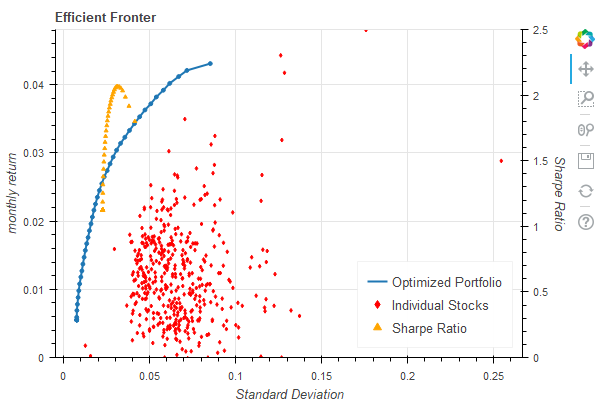

In [32]:
(weight1,ret1,std1,sharpe1) = compute_frontier(DF4, risk_free_rate = 0.02)


p1 = figure(x_axis_label = "Standard Deviation", y_axis_label = "monthly return", plot_width=600, plot_height=400, title="Efficient Fronter")

# add a line renderer
p1.line(std1, ret1, line_width=2, legend = "Optimized Portfolio")

# add individual simulation point
p1.circle(std1,ret1,size = 4)

# add individual point for each stock
p1.diamond(compute_std(DF4).values, compute_mean_return(DF4).values, color = "red", size = 4, legend = "Individual Stocks")

p1.y_range = Range1d(0,np.nanmax(ret1) + 0.005)


# add the sharpe ratio for the portfolio as the second y axis
p1.extra_y_ranges = {"sharpe":Range1d(start = 0, end = 2.5)}
p1.add_layout(LinearAxis(y_range_name = "sharpe", axis_label='Sharpe Ratio'), "right")
p1.triangle(std,sharpe, size = 4, color = "orange", y_range_name = "sharpe", legend = "Sharpe Ratio")
p1.legend.location = "bottom_right"

show(p1)

# export to png
try:
    export_png(p1, filename="Fig 1.2.PNG")
except:
    pass



try:
    display(Image(filename = "Fig 1.2.PNG"))
except:
    pass


